In [2]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install torchmetrics
!pip install torchinfo
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install matplotlib.pyplot
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


Defaulting to user installation because normal site-packages is not writeable


Imports

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torchmetrics import *

from torch.utils.data import *

from sklearn.preprocessing import MinMaxScaler

import pandas as pd

import matplotlib.pyplot as plt


import yfinance as yf


Data Processing

In [4]:
# time step to predict ahead, creates input sequences
# gonna have to figure out test
def create_lstm_data(data, time_step=1, future = 0,test_percent = .1):
    x_vec, y_vec = [], []
    # formats data so y = t and x = t-1, ... , t-time_steps
    for i in range(len(data) - time_step):
        split = i + time_step
        # checks if data is of same length for concatentation
        length = data[split : split + future, 0].shape[0]
        if(length == future):
            x_vec.append(data[i : split, 0].unsqueeze(0))
            y_vec.append(data[split : split + future, 0].unsqueeze(0))
    # calculate number of elements to allocate to test
    #dataset_length = len(x_vec)
    #num_of_train = dataset_length - (int)(test_percent * dataset_length)
    # concats x into matrix and y into vector, needs unsqueez to add single dimension for LSTM
    return torch.cat(x_vec,0).unsqueeze(-1), torch.cat(y_vec,0).unsqueeze(-1)#, torch.cat(x_vec[num_of_train:],0).unsqueeze(-1), torch.cat(y_vec[num_of_train:],0).unsqueeze(-1)

# create a dataset out of timeseries data, must be formatted first, tensor
# correct timeseries formatation
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]
    

In [5]:
def create_train_dataset(pairs, input_size, output_size, train_test_ratio = 0.8):
    """Given set of pairs this creates a train and test dataset to train and test the model on

    Args:
        pairs (string, string): Pair of stocks
        input_size (int): Window of days to train on
        output_size (int): Window of days to predict
        train_test_ratio (float): Percent of data to be assign to train and test

    Returns:
        Dataset: Dataset of all pairs to train on
    """
    
    train_dataset_list = []
    test_dataset_list = []
    
    scaler = MinMaxScaler(feature_range=(0,1))
    
    for (x, y) in pairs:
        # Get the spread for a pair
        x_data = yf.download(x, period='10y')['Close']
        y_data = yf.download(y, period='10y')['Close']
        spread = x_data - y_data
        spread = spread.values.reshape(-1,1)
        
        # Normalize the data
        normalized_data = torch.tensor(scaler.fit_transform(spread))
        train_test_split = (int)(len(normalized_data) * train_test_ratio)
        
        # Split data into train and test
        train_data = normalized_data[:train_test_split]
        test_data = normalized_data[train_test_split:]
        # Create train dataset
        X_train, y_train = create_lstm_data(train_data, input_size, output_size)
        train_dataset_i = TimeSeriesDataset(X_train,y_train)
        train_dataset_list.append(train_dataset_i)
        # Create test dataset
        X_test, y_test = create_lstm_data(test_data, input_size, output_size)
        test_dataset_i = TimeSeriesDataset(X_test,y_test)
        test_dataset_list.append(test_dataset_i)
        
    train_dataset = torch.utils.data.ConcatDataset(train_dataset_list)
    test_dataset = torch.utils.data.ConcatDataset(test_dataset_list)
    
    return train_dataset, test_dataset

Model Architecture

In [6]:
#possibly change how layers of encoder to decoder are handled (possibly make different sizes)
#maybe bidirectional? i dont thinks so
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout = 0.5):
        super(Encoder,self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout,
                           batch_first=True)

    def forward(self, x):
        
        outputs, (hidden, cell) = self.rnn(x)
        
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout = 0.5):
        super(Decoder,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout,
                           )
        self.fc_out = nn.Linear(hidden_dim, 1)

    #predicts a single time step, with either y pred as input or y
    def forward(self, y, prev_hidden, prev_cell):

        y = y.unsqueeze(0)

        output, (hidden, cell) = self.rnn(y, (prev_hidden, prev_cell))

        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell
    
class EncoderDecoderWrapper(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.5, output_size = 1, teacher_forcing=0.3, device = 'cpu'):
        super(EncoderDecoderWrapper,self).__init__()
        self.encoder = Encoder(input_dim,num_layers,hidden_dim,dropout)
        self.decoder = Decoder(input_dim,num_layers,hidden_dim,dropout)
        self.teacher_forcing = teacher_forcing
        self.device = device
        self.output_size = output_size

    def forward(self, source, target=None):
        
        # num of elements in each batch
        batch_size = source.shape[0]
        #should be same size as output
        
        if(target != None):
            target_len = target.shape[1]
        
            assert(target_len == self.output_size)
        
        prev_hidden, prev_cell = self.encoder(source)

        prev_target = source[:,-1]
            
        outputs = torch.zeros(batch_size,self.output_size).to(self.device)
        
        for t in range(self.output_size):
            
            prediction, prev_hidden, prev_cell = self.decoder(prev_target, prev_hidden, prev_cell)

            outputs[:,t] = prediction.squeeze(1)
            
            #chance of using actual vs chance of using predicted in training
            prev_target = target[:,t] if torch.rand(1) < self.teacher_forcing and target != None else prediction
        
        return outputs

Training Loop

In [7]:
def train_epoch(model,dataloader,loss_fn,optimizer,device = 'cpu'):
    
    model.train()
    running_loss = 0.0

    for X, y in dataloader:
        X_train, y_train = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        output = model(X_train, y_train)
        loss = loss_fn(output, y_train.squeeze(2))
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss = running_loss / len(dataloader)
    print(f'Train Average Loss: {avg_loss}')

Formatting Data

In [8]:
# Parameters for data
BATCH_SIZE = 128
input_size = 30
output_size = 60

In [9]:
# Pairs to train model on
pairs = [('HMC','HYMTF'),('CSGP','PLD'),("TJX","DLTR"),("AEP",'XEL'),
         ("AMD","NXPI"),("AMD","ADI"),("QCOM","TSM"),("QCOM","NXPI"),
         ("ABBV",'AMGN'),("CRM","WDAY"),("COF","DFS"),("YUM","DRI")]

train_dataset, test_dataset = create_train_dataset(pairs, input_size, output_size)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Training

In [10]:
# Hyper parameters
input_dim = 1
num_layers = 2
hidden_size = 10
dropout = 0.5
teacher_forcing = 0.2

device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EncoderDecoderWrapper(input_dim,num_layers,hidden_size,dropout,output_size,teacher_forcing,device).to(device)

In [11]:
lr = 0.001
num_epochs = 5
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [12]:
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    train_epoch(model, train_dataloader, loss, optimizer,device)

Epoch: 0
Train Average Loss: 0.11777622997760773
Epoch: 1
Train Average Loss: 0.03364577516913414
Epoch: 2
Train Average Loss: 0.032517191022634506
Epoch: 3
Train Average Loss: 0.0318622812628746
Epoch: 4
Train Average Loss: 0.03142916038632393


Testing

torch.Size([415, 60]) | torch.Size([415, 30, 1]) | torch.Size([415, 60, 1])


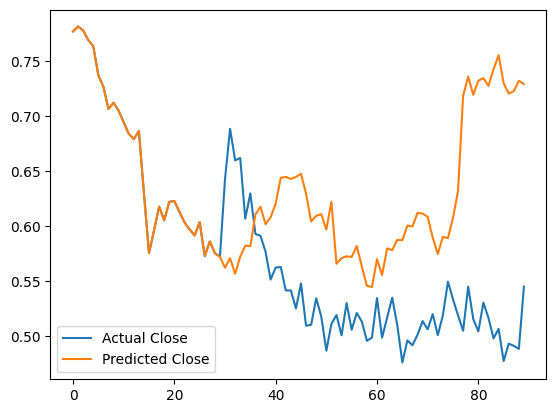

In [38]:
X = test_dataset.datasets[1].X 
y = test_dataset.datasets[1].y
with torch.inference_mode():
    predicted = model(X.to(device).to(torch.float32)).to(device)

#y_train = format_back(y_train, 7)
#y_pred = format_back(predicted, 7)

print(f'{predicted.shape} | {X.shape} | {y.shape}')

i = 390

pred_with_x = torch.concat([X.cpu().squeeze(2),predicted.cpu()],1)
y_with_x = torch.concat([X.cpu().squeeze(2),y.cpu().squeeze(2)],1)

#true_y_train = scaler.inverse_transform(pred_with_x)
#true_y_pred = scaler.inverse_transform(y_with_x)

plt.plot(pred_with_x[i], label = 'Actual Close')
plt.plot(y_with_x[i], label = 'Predicted Close')
plt.legend()

#true_y_pred[1], true_y_train[1]

In [14]:
len(train_dataloader)

181